In [1]:
from keras.models import load_model



In [2]:
model = load_model('model_edged.h5')

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        18496     
                                                           

In [3]:
import cv2
import numpy as np
from keras.models import load_model

# Load the model
model = load_model('model_edged.h5') 
IMG_SIZE = 100  



In [5]:
alphabet = {chr(i+96).upper(): i for i in range(1, 27)}
#alphabet['del'] = 27
#alphabet['nothing'] = 28
#alphabet['space'] = 29
print(alphabet)

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


### Model

In [16]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load CSV file
csv_file_path = r'C:\Users\yaswa\Desktop\OpenCV\asl_recognition-master\ASL-Reader\asl_data2\train\_annotations.csv'
df = pd.read_csv(csv_file_path)

In [17]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg,390,390,U,38,69,347,389
1,P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg,372,372,P,84,203,330,332
2,K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg,372,372,K,42,12,351,369
3,W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg,412,412,W,22,73,377,412
4,J30_jpg.rf.00d20e595026b31773ded47509545471.jpg,382,382,J,122,204,250,334
...,...,...,...,...,...,...,...,...
1507,C14_jpg.rf.ff63309f35ce9f8a7b30b006a4181045.jpg,408,408,C,111,76,306,342
1508,A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg,394,394,A,101,57,315,229
1509,A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg,406,406,A,53,104,352,338
1510,W20_jpg.rf.fffe2d54b2d00bbad942f6a406503d87.jpg,374,374,W,135,67,313,318


In [18]:
# Define preprocess_image function
def preprocess_image(row, target_size=(224, 224)):
    image_path = f'C:/Users/yaswa/Desktop/OpenCV/asl_recognition-master/ASL-Reader/asl_data2/train/{row["filename"]}'
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Crop image using bounding box coordinates
    cropped_image = image[row['ymin']:row['ymax'], row['xmin']:row['xmax']]

    # Resize image
    resized_image = cv2.resize(cropped_image, target_size)

    # Normalize image
    normalized_image = resized_image.astype('float32') / 255.0

    return normalized_image

In [19]:

# Apply preprocess_image function to the DataFrame
X = np.array([preprocess_image(row) for _, row in df.iterrows()])
y = df['class'].values

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X.shape

(1512, 224, 224, 3)

In [22]:
y.shape

(1512,)

In [15]:
y

array(['U', 'P', 'K', ..., 'A', 'W', 'S'], dtype=object)

In [109]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Define the model (same as before)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')  # Assuming 26 classes for the alphabet letters
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with numerical labels and validate
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numerical labels back to original string labels for classification report
y_val_original = label_encoder.inverse_transform(y_val_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate classification report
report = classification_report(y_val_original, y_pred_original)
print(report)


Epoch 1/10
38/38 [==============================] - 41s 1s/step - loss: 3.4354 - accuracy: 0.0430 - val_loss: 3.2218 - val_accuracy: 0.0561
Epoch 2/10
38/38 [==============================] - 39s 1s/step - loss: 3.0073 - accuracy: 0.1489 - val_loss: 2.9799 - val_accuracy: 0.1980
Epoch 3/10
38/38 [==============================] - 39s 1s/step - loss: 2.1919 - accuracy: 0.4218 - val_loss: 2.2837 - val_accuracy: 0.3993
Epoch 4/10
38/38 [==============================] - 39s 1s/step - loss: 0.9881 - accuracy: 0.7486 - val_loss: 1.8610 - val_accuracy: 0.5050
Epoch 5/10
38/38 [==============================] - 39s 1s/step - loss: 0.3479 - accuracy: 0.9239 - val_loss: 1.7571 - val_accuracy: 0.5974
Epoch 6/10
38/38 [==============================] - 39s 1s/step - loss: 0.0944 - accuracy: 0.9835 - val_loss: 1.7455 - val_accuracy: 0.6502
Epoch 7/10
38/38 [==============================] - 39s 1s/step - loss: 0.0510 - accuracy: 0.9909 - val_loss: 1.8863 - val_accuracy: 0.6073
Epoch 8/10
38/38 [==

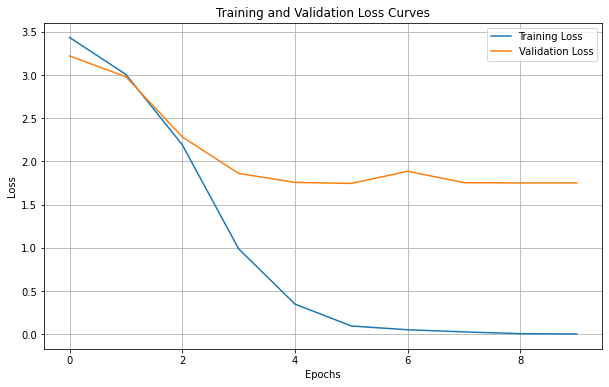

In [111]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


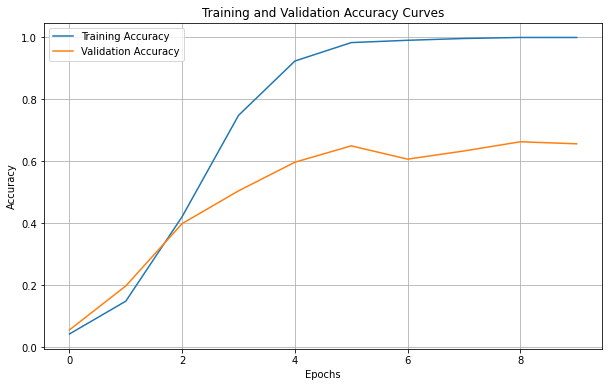

In [112]:


# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()


### Early stopping

In [113]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Define the model (same as before)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')  # Assuming 26 classes for the alphabet letters
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with numerical labels and validate, using EarlyStopping callback
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numerical labels back to original string labels for classification report
y_val_original = label_encoder.inverse_transform(y_val_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate classification report
report = classification_report(y_val_original, y_pred_original)
print(report)


Epoch 1/100
38/38 [==============================] - 42s 1s/step - loss: 3.8492 - accuracy: 0.0653 - val_loss: 3.2225 - val_accuracy: 0.0825
Epoch 2/100
38/38 [==============================] - 40s 1s/step - loss: 2.9122 - accuracy: 0.2101 - val_loss: 2.9741 - val_accuracy: 0.2013
Epoch 3/100
38/38 [==============================] - 40s 1s/step - loss: 2.0556 - accuracy: 0.4566 - val_loss: 2.3797 - val_accuracy: 0.3762
Epoch 4/100
38/38 [==============================] - 42s 1s/step - loss: 1.0375 - accuracy: 0.7337 - val_loss: 1.7634 - val_accuracy: 0.5413
Epoch 5/100
38/38 [==============================] - 41s 1s/step - loss: 0.4879 - accuracy: 0.8999 - val_loss: 1.5647 - val_accuracy: 0.5974
Epoch 6/100
38/38 [==============================] - 40s 1s/step - loss: 0.1984 - accuracy: 0.9669 - val_loss: 1.7462 - val_accuracy: 0.5479
Epoch 7/100
38/38 [==============================] - 41s 1s/step - loss: 0.0679 - accuracy: 0.9934 - val_loss: 1.6109 - val_accuracy: 0.6337
Epoch 8/100
1

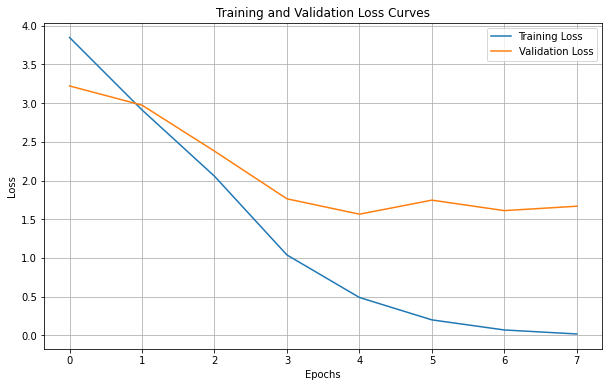

In [114]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


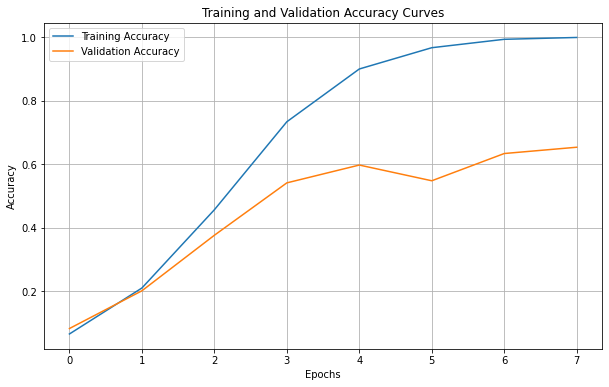

In [115]:


# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()


In [116]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Define the model with increased complexity
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(26, activation='softmax')  # Assuming 26 classes for the alphabet letters
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with numerical labels and validate, using EarlyStopping callback
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numerical labels back to original string labels for classification report
y_val_original = label_encoder.inverse_transform(y_val_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate classification report
report = classification_report(y_val_original, y_pred_original)
print(report)


Epoch 1/100
38/38 [==============================] - 147s 4s/step - loss: 3.4650 - accuracy: 0.0364 - val_loss: 3.2576 - val_accuracy: 0.0198
Epoch 2/100
38/38 [==============================] - 151s 4s/step - loss: 3.2530 - accuracy: 0.0637 - val_loss: 3.2608 - val_accuracy: 0.0396
Epoch 3/100
38/38 [==============================] - 112s 3s/step - loss: 3.2182 - accuracy: 0.0662 - val_loss: 3.1614 - val_accuracy: 0.1254
Epoch 4/100
38/38 [==============================] - 115s 3s/step - loss: 2.9896 - accuracy: 0.1754 - val_loss: 2.6846 - val_accuracy: 0.2838
Epoch 5/100
38/38 [==============================] - 126s 3s/step - loss: 2.5730 - accuracy: 0.2953 - val_loss: 2.3694 - val_accuracy: 0.3366
Epoch 6/100
38/38 [==============================] - 124s 3s/step - loss: 2.1163 - accuracy: 0.4218 - val_loss: 2.2038 - val_accuracy: 0.4257
Epoch 7/100
38/38 [==============================] - 127s 3s/step - loss: 1.5243 - accuracy: 0.5666 - val_loss: 1.9083 - val_accuracy: 0.5017
Epoch 

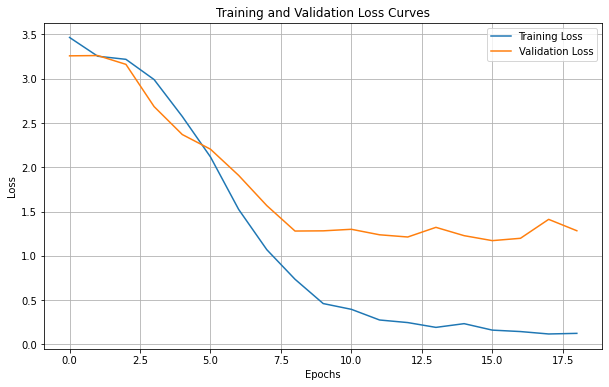

In [117]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


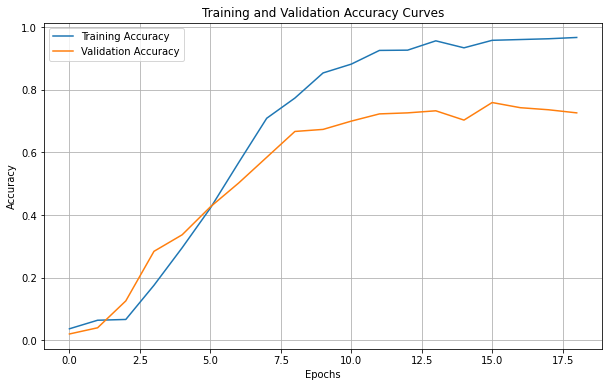

In [118]:


# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
!pip install efficientnet

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0  # Import EfficientNetB0

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Create the EfficientNetB0 model
efficientnet_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers in the pre-trained model
efficientnet_model.trainable = False

# Build the complete model by adding layers on top of EfficientNetB0
model = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(26, activation='softmax')  # Assuming 26 classes for the alphabet letters
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with numerical labels and validate, using EarlyStopping callback
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)

# Convert numerical labels back to original string labels for classification report
y_val_original = label_encoder.inverse_transform(y_val_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Generate classification report
report = classification_report(y_val_original, y_pred_original)
print(report)


c:\users\yaswa\appdata\local\programs\python\python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
38/38 [==============================] - 90s 2s/step - loss: 6.9229 - accuracy: 0.1381 - val_loss: 2.2557 - val_accuracy: 0.4257
Epoch 2/100
38/38 [==============================] - 71s 2s/step - loss: 3.0972 - accuracy: 0.2291 - val_loss: 1.9405 - val_accuracy: 0.5149
Epoch 3/100
38/38 [==============================] - 68s 2s/step - loss: 2.8459 - accuracy: 0.3251 - val_loss: 1.5625 - val_accuracy: 0.6040
Epoch 4/100
38/38 [==============================] - 68s 2s/step - loss: 2.5119 - accuracy: 0.3929 - val_loss: 1.5114 - val_accuracy: 0.6238
Epoch 5/100
38/38 [==============================] - 68s 2s/step - loss: 2.2186 - accuracy: 0.4789 - val_loss: 1.1172 - val_accuracy: 0.7195
Epoch 6/100
38/38 [==============================] - 68s 2s/step - loss: 1.9883 - accuracy: 0.5360 - val_loss: 1.0429 - val_accuracy: 0.7690
Epoch 7/100
38/38 [==============================] - 68s 2s/step - loss: 1.7676 - accuracy: 0.5798 - val_loss: 0.8857 - val_accuracy: 0.7789
Epoch 8/100
3

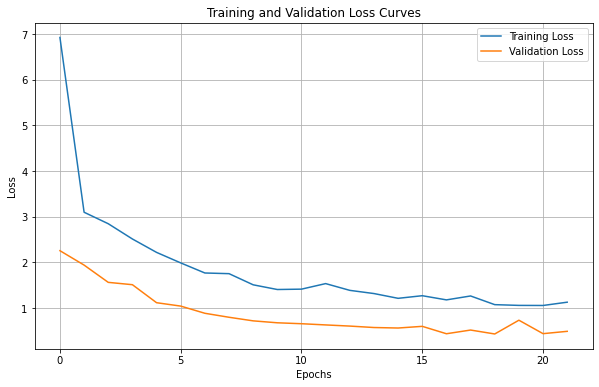

In [26]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


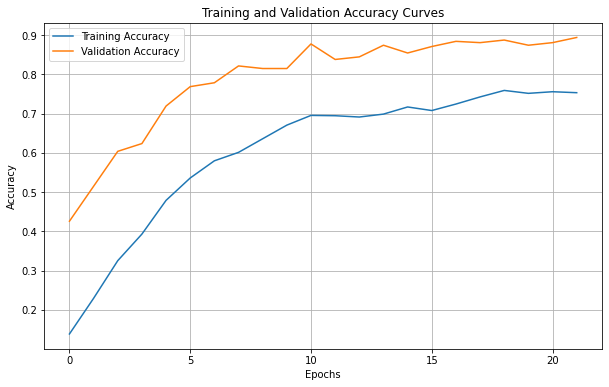

In [27]:


# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
print('hi')

hi


In [34]:
model.save('./efficient_model.h5')

In [30]:
print(y_pred[0])

[4.37570881e-04 4.21172124e-04 5.10182139e-03 4.97520203e-04
 1.03430240e-03 3.18203442e-04 6.56970311e-04 4.89184575e-04
 9.48220899e-04 6.78085635e-05 7.78966059e-04 1.25765699e-04
 5.27083059e-04 8.98627331e-04 3.21403183e-02 3.73962510e-04
 4.27334890e-04 5.50031662e-02 5.00127347e-03 1.63067749e-03
 8.87841761e-01 3.95014603e-03 4.00808960e-04 7.69748411e-04
 1.12660935e-04 4.49825166e-05]


In [33]:
y_pred.argmax(axis=-1)[0]

20

In [35]:
X_val.shape

(303, 224, 224, 3)